# Série temporelle multivariée avec RNN

## VEUILLEZ LIRE CE QUI SUIT AVANT DE PARCOURIR CE NOTEBOOK !

**En général, il est très difficile d'obtenir de bonnes performances à partir d'un modèle RNN basé sur le LSTM pour les séries multivariées. Nous recommandons vivement l'utilisation des méthodes basées sur SARIMAX si vous avez une situation réelle nécessitant des données de séries temporelles à plusieurs variables.**

## Données

Consommation d'énergie des appareils électroménagers : Un exemple de prévision de séries temporelles multivariées

Données expérimentales utilisées pour créer des modèles de régression de la consommation d'énergie des appareils dans un bâtiment à faible consommation d'énergie.

Informations sur les ensembles de données :

L'ensemble de données contient des enregistrements de différentes features toutes les 10 min pendant environ 4,5 mois. Les conditions de température et d'humidité de la maison ont été surveillées à l'aide d'un réseau de capteurs sans fil ZigBee. Chaque nœud sans fil a transmis les conditions de température et d'humidité pendant environ 3,3 min. Ensuite, la moyenne des données sans fil a été calculée sur des périodes de 10 minutes. Les données énergétiques ont été enregistrées toutes les 10 minutes avec des compteurs d'énergie m-bus. La météo de la station météorologique de l'aéroport le plus proche (aéroport de Chievres, Belgique) a été téléchargée à partir d'un ensemble de données publiques de Pronostic Fiable (rp5.ru), et fusionnée avec les ensembles de données expérimentales à l'aide de la colonne date et heure. Deux variables aléatoires ont été incluses dans l'ensemble de données pour tester les modèles de régression et pour filtrer les attributs non prédictifs (paramètres).

Source originale de l'ensemble de données :

[https://archive.ics.uci.edu/ml/datasets/Appliances+energy+prediction](https://archive.ics.uci.edu/ml/datasets/Appliances+energy+prediction)

## Changements à apporter pour les données multivariées

Les changements à mettre en place pour les données multivariées en LSTM sont les suivants:
- Modifier la forme de l'entrée dans la couche LSTM pour refléter la structure 2D de la forme de l'entrée
- La couche dense finale doit avoir un neurone par feature /variable.

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [52]:
df = pd.read_csv('energy.csv',index_col='date', infer_datetime_format=True)
df.index = pd.to_datetime(df.index)
print(df.shape)
df.head()

(19735, 28)


C:\Users\hajdaini\AppData\Local\Temp\ipykernel_16068\3119781534.py:1: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv('energy.csv',index_col='date', infer_datetime_format=True)


,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
date,,,,,,,,,,,,,,,,,,,,,
2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,...,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,...,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,...,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668
2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,...,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389
2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,...,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097


In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19735 entries, 2016-01-11 17:00:00 to 2016-05-27 18:00:00
Data columns (total 28 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Appliances   19735 non-null  int64  
 1   lights       19735 non-null  int64  
 2   T1           19735 non-null  float64
 3   RH_1         19735 non-null  float64
 4   T2           19735 non-null  float64
 5   RH_2         19735 non-null  float64
 6   T3           19735 non-null  float64
 7   RH_3         19735 non-null  float64
 8   T4           19735 non-null  float64
 9   RH_4         19735 non-null  float64
 10  T5           19735 non-null  float64
 11  RH_5         19735 non-null  float64
 12  T6           19735 non-null  float64
 13  RH_6         19735 non-null  float64
 14  T7           19735 non-null  float64
 15  RH_7         19735 non-null  float64
 16  T8           19735 non-null  float64
 17  RH_8         19735 non-null  float64
 18  T9         

First date: 2016-01-11 17:00:00
Last date: 2016-05-27 18:00:00


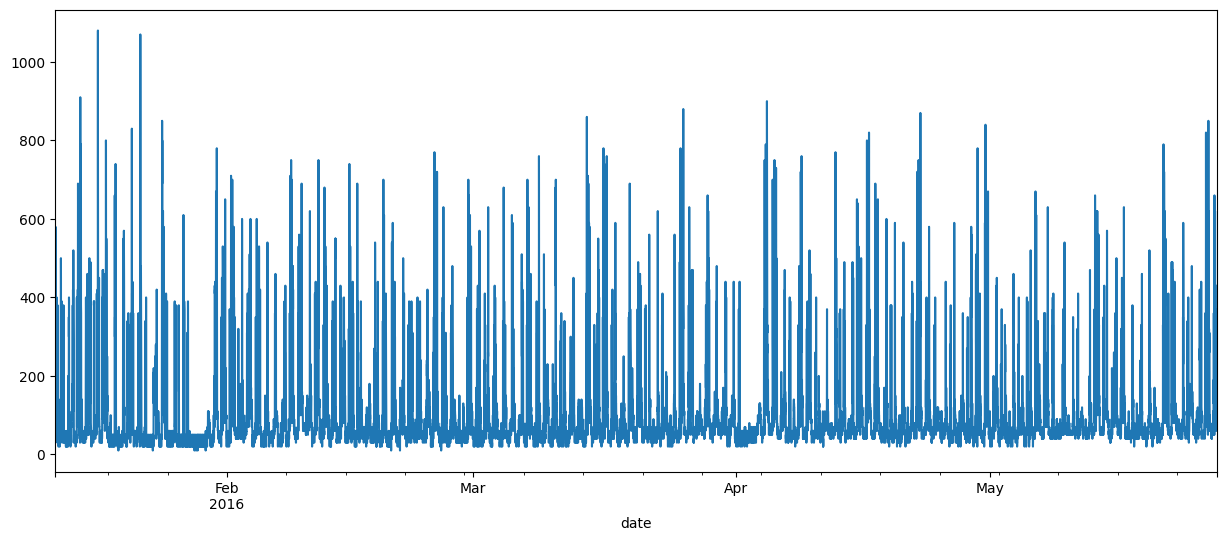

In [54]:
print("First date:", df.index[0])
print("Last date:", df.index[-1])
df["Appliances"].plot(figsize=(15, 6)); # beaucoup de valeurs x car on prends des mesures toutes les 10 minutes

Arrondissons également les données, avec une précision d'une décimale, sinon cela pourrait causer des problèmes avec notre réseau car cela peut provoquer plus de bruits (nous normaliserons également les données de toute façon, donc ce niveau de précision ne nous est pas utile)

In [55]:
df = df.round(2)
df.head()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
date,,,,,,,,,,,,,,,,,,,,,
2016-01-11 17:00:00,60,30,19.89,47.60,19.2,44.79,19.79,44.73,19.00,45.57,...,17.03,45.53,6.60,733.5,92.0,7.00,63.00,5.3,13.28,13.28
2016-01-11 17:10:00,60,30,19.89,46.69,19.2,44.72,19.79,44.79,19.00,45.99,...,17.07,45.56,6.48,733.6,92.0,6.67,59.17,5.2,18.61,18.61
2016-01-11 17:20:00,50,30,19.89,46.30,19.2,44.63,19.79,44.93,18.93,45.89,...,17.00,45.50,6.37,733.7,92.0,6.33,55.33,5.1,28.64,28.64
2016-01-11 17:30:00,50,40,19.89,46.07,19.2,44.59,19.79,45.00,18.89,45.72,...,17.00,45.40,6.25,733.8,92.0,6.00,51.50,5.0,45.41,45.41
2016-01-11 17:40:00,60,40,19.89,46.33,19.2,44.53,19.79,45.00,18.89,45.53,...,17.00,45.40,6.13,733.9,92.0,5.67,47.67,4.9,10.08,10.08


Imaginons que nous voulions prédire seulement 24 heures dans le futur, nous n'avons pas besoin de 3 mois de données pour cela, alors économisons un peu de temps d'entraînement et sélectionnons seulement les données des derniers mois.

In [56]:
# Prenez les données des trois derniers mois
df_cropped = df.last('3M')
print("First date:", df_cropped.index[0])
print("Last date:", df_cropped.index[-1])


First date: 2016-02-29 18:10:00
Last date: 2016-05-27 18:00:00


C:\Users\hajdaini\AppData\Local\Temp\ipykernel_16068\1106758636.py:2: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  df_cropped = df.last('3M')


In [57]:
def calculate_rows(days):
    # Il y a 24 heures dans une journée, 60 minutes dans une heure et chaque ligne correspond à 10 minutes
    rows = days * 24 * 60 / 10
    return int(rows)

test_days = 2
rows = calculate_rows(test_days)
train = df_cropped[:-rows]
test = df_cropped[-rows:]
print(rows)
print(train.shape)
print(test.shape)

288
(12384, 28)
(288, 28)


## Normalisation

In [59]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

## Génération des séries temporelles 

In [60]:
from keras.preprocessing.sequence import TimeseriesGenerator
length = 144 # 24 heures
batch_size = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=batch_size)
validation_generator = TimeseriesGenerator(scaled_test, scaled_test, length=length, batch_size=batch_size)

In [61]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

In [ ]:
nb_features = scaled_train.shape[1] # on doit prédire toutes les colonnes de notre dataset
def create_model():
    model = Sequential()
    model.add(LSTM(100, activation='relu', input_shape=(length, nb_features)))
    model.add(Dense(nb_features))
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

model = create_model()
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 100)               51600     
                                                                 
 dense_2 (Dense)             (None, 28)                2828      
                                                                 
Total params: 54428 (212.61 KB)
Trainable params: 54428 (212.61 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [67]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=2)
model.fit(generator, epochs=50, validation_data=validation_generator, callbacks=[early_stop])
epochs_processed = len(model.history.epoch)
loss = model.history.history['loss']
val_loss = model.history.history['val_loss']

Epoch 1/50


  910/12240 [=>............................] - ETA: 5:35 - loss: nan - mae: nan

In [ ]:
epochs = range(len(loss))

plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(epochs, model.history.history['mae'], label='Training MAE')
plt.plot(epochs, model.history.history['val_mae'], label='Validation MAE')
plt.title('Model Loss and MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

In [68]:
nb_features = scaled_train.shape[1]
test_predictions = []
first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, nb_features))
for i in range(len(test)):
    current_pred = model.predict(current_batch)[0]
    test_predictions.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis=1)


1/1 [==============================] - 0s 27ms/step


KeyboardInterrupt: 

In [ ]:
true_predictions = scaler.inverse_transform(test_predictions)

In [ ]:
plt.figure(figsize=(12, 6))

# Iterate over each column in the test data
for column in test.columns:
    plt.plot(test.index, test[column], label='Actual ' + column)

# Iterate over each column in the true predictions
for i, column in enumerate(test.columns):
    plt.plot(test.index, true_predictions[:, i], label='Predicted ' + column)

plt.title('Comparison of Test Data with True Predictions')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()